In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag='1.9.1.8.5_JorstadAll_final_noQ_INP'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)

In [3]:
# adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/jorstad_merge_all.h5ad'),backed='r')
adata = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/jorstad_merge_all.h5ad'),
    mode='r', selected_keys=['batch','organism','UMIs','var','uns'])

adata.uns['species_colors']=['blue','red','green','yellow','orange','cyan','magenta','teal','goldenrod','purple','maroon','pink','violet','black','grey','beige']
batch_key='batch'
discov_key='organism'
layer_key='UMIs'

species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer=layer_key,normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 5/5 [02:20<00:00, 28.00s/it]


In [4]:
del adata.raw

In [5]:
# adata

In [6]:
# num_var=adata.shape[1]
# batch_size=32
# level_sizes=[1,30,200]
# num_latent=150
# steps=0
# max_steps=600000
# num_particles=3
# print_every=5000

# # Clear Pyro param store so we don't conflict with previous run
# try:
#     pyro.clear_param_store()
#     del antipode_model
#     torch.cuda.empty_cache()
# except:
#     pass
# # Fix random number seed to a lucky number
# pyro.util.set_rng_seed(13)
# # Enable optional validation warnings
# pyro.enable_validation(False)

# # Instantiate instance of model/guide and various neural networks
# antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,bi_depth=2,num_batch_embed=10,psi_levels=[0.,1.,1.],
#                 adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=1e-1,
#                 use_psi=False,use_q_score=False,prior_scale=50.,theta_prior=10,sampler_category=discov_key,dist_normalize=False,dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),
#                 scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=False)

In [7]:
# antipode_model.run_standard_protocol(out_path,
#                                      max_steps=max_steps,
#                                      num_particles=num_particles,
#                                      device=device,
#                                      max_learning_rate=1e-3,
#                                      one_cycle_lr=True,
#                                      batch_size=batch_size)

In [8]:
# adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')

In [9]:
antipode_model=ANTIPODE.load(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),adata=adata,prefix='p4_',device=device)
adata=antipode_model.adata_manager.adata
antipode_model.store_outputs(device=device,prefix='')

In [10]:
# antipode_model.to(device)
# posterior_out,posterior_categories = antipode_model.correct_fits(batch_size=128, n_steps = 100000)
# antipode_model.store_outputs(device=device,prefix='')


In [11]:
!nvidia-smi
antipode_model.clear_cuda()
!nvidia-smi

Mon Feb 10 09:08:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:B1:00.0 Off |                    0 |
| N/A   38C    P0             36W /  250W |    1343MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [12]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

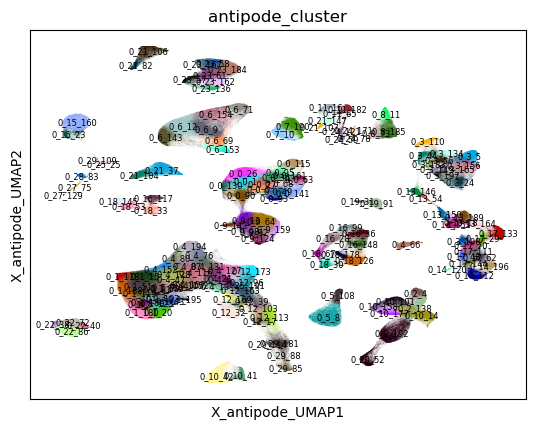

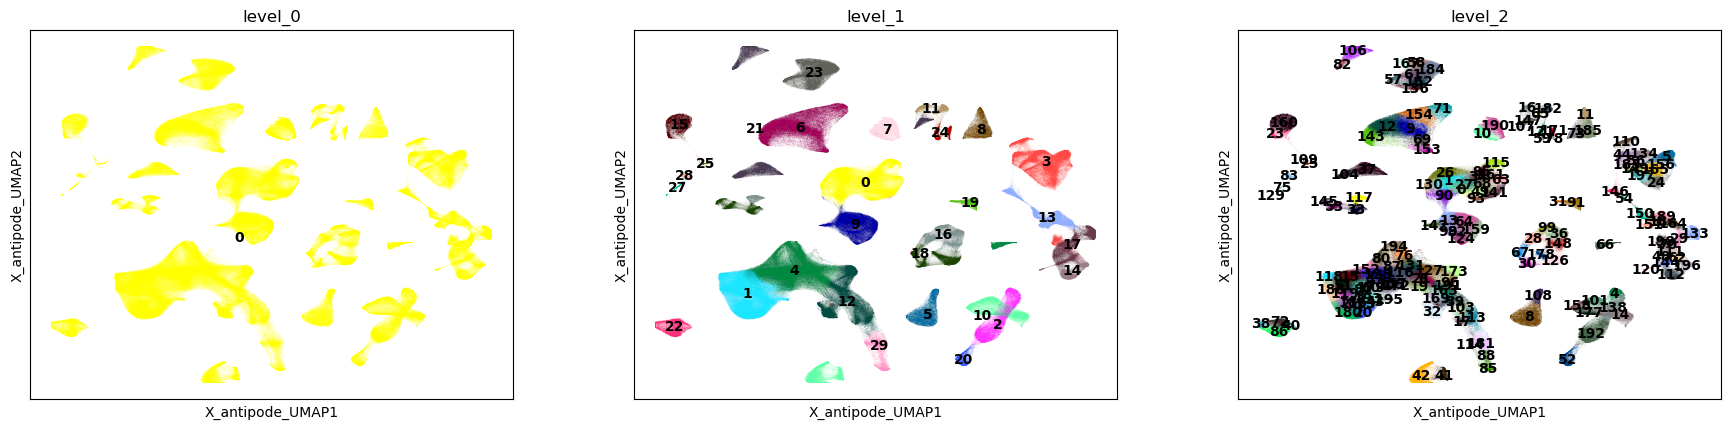

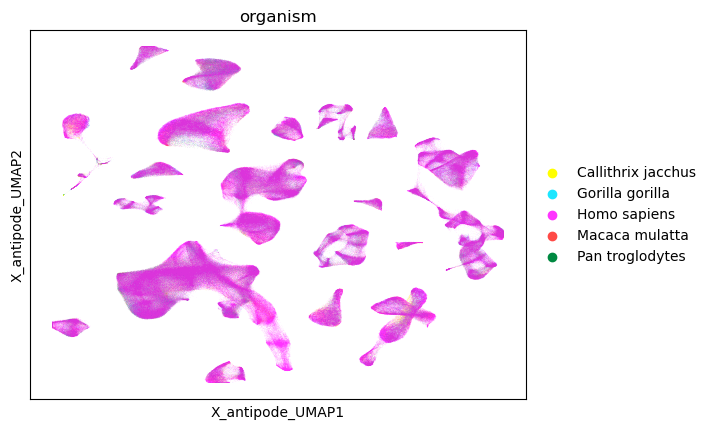

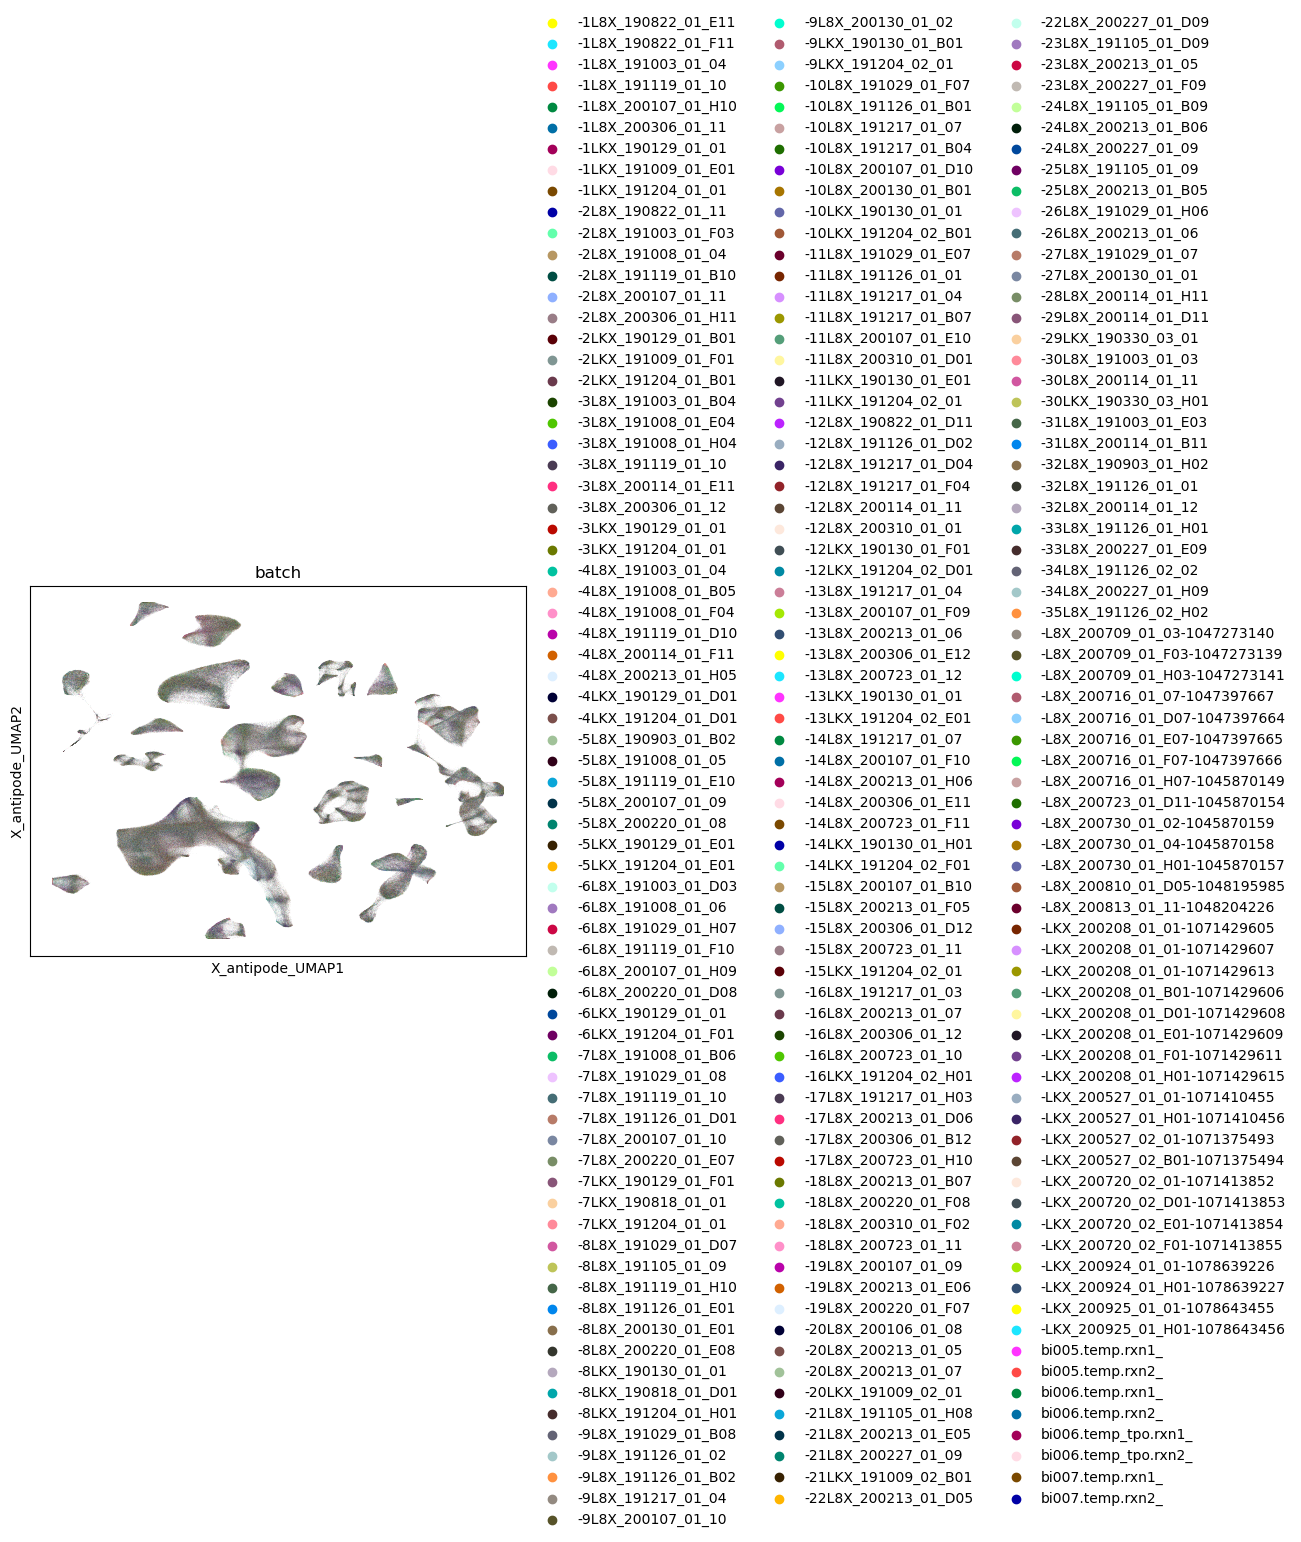

In [13]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key]
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    palette=sc.pl.palettes.godsnot_102,
    color=[batch_key],cmap='coolwarm'
)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


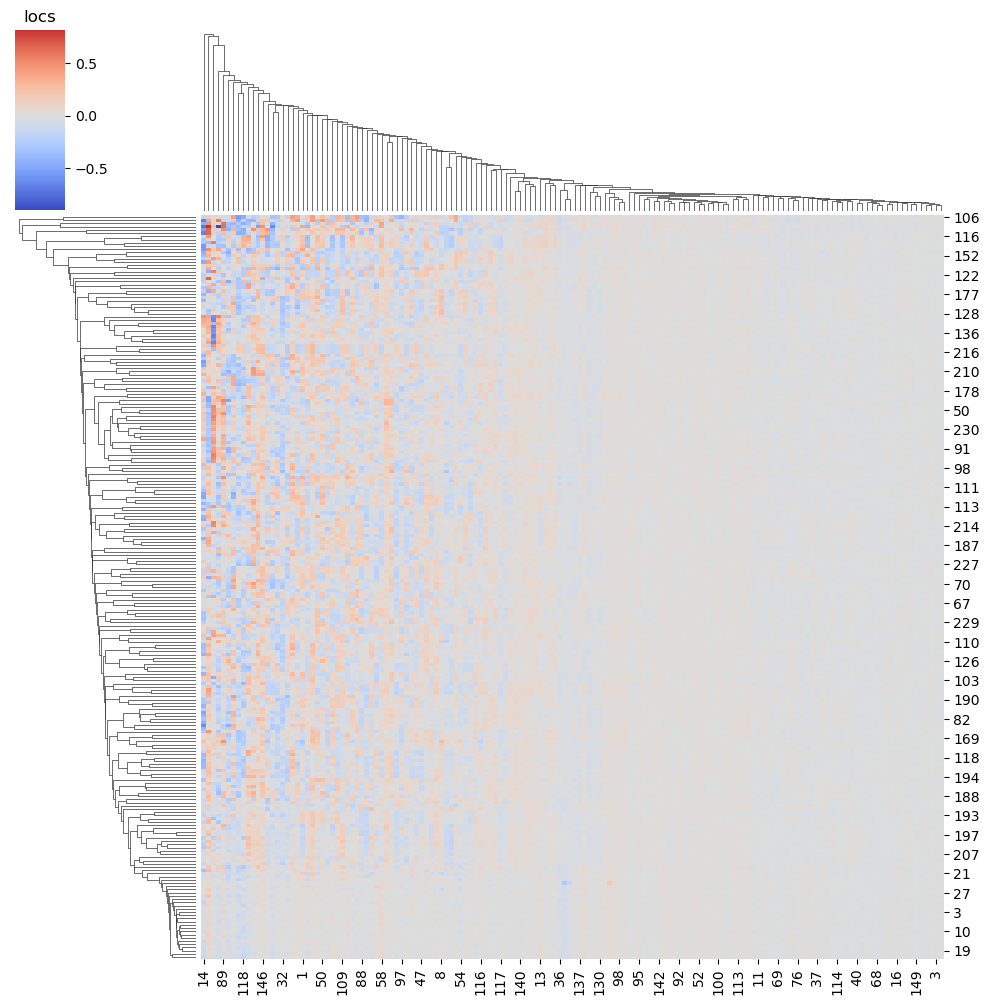

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


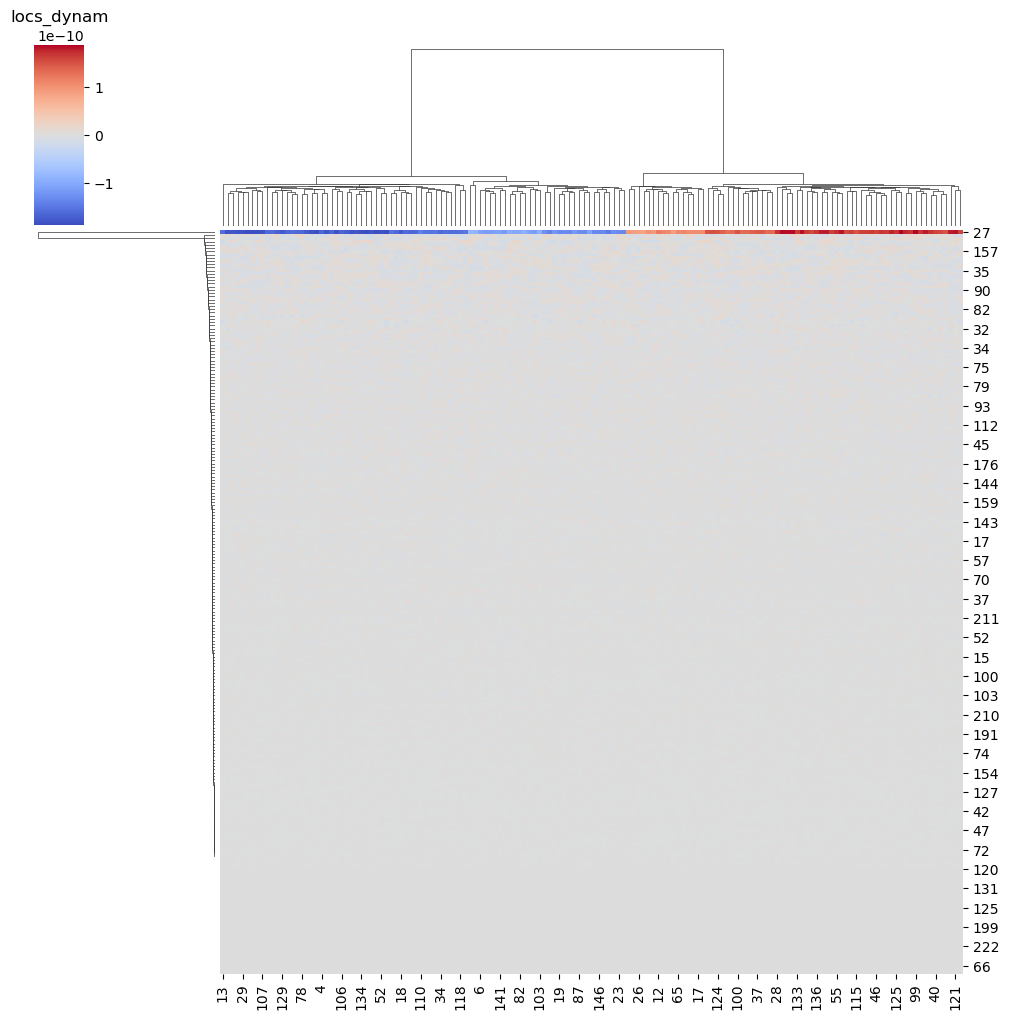

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


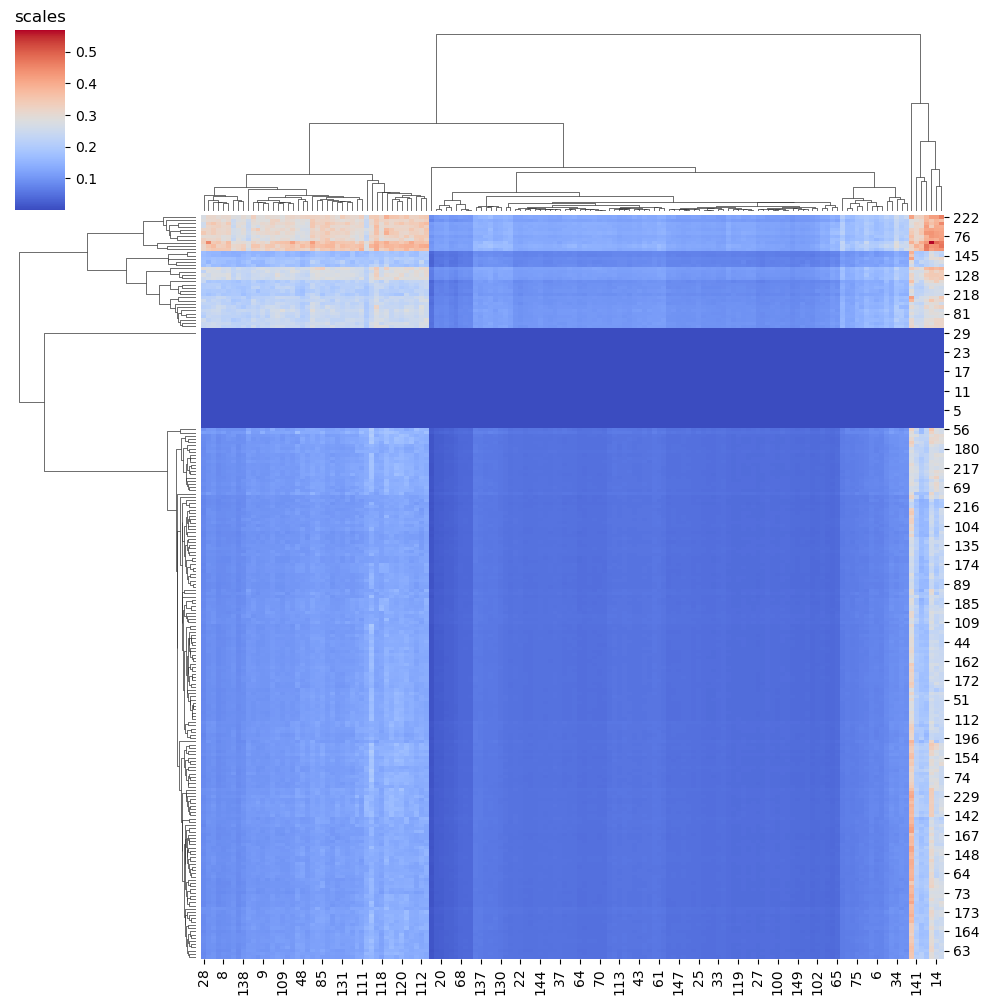

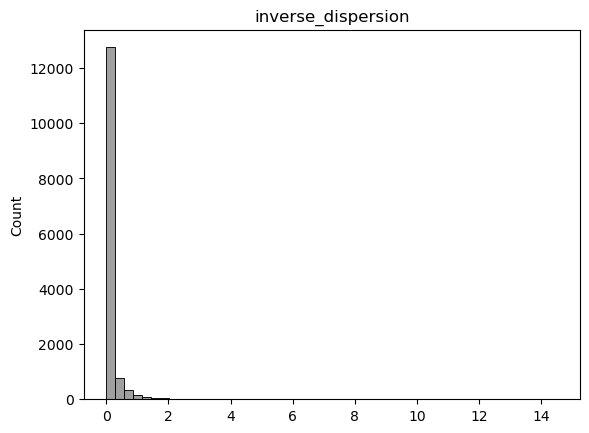

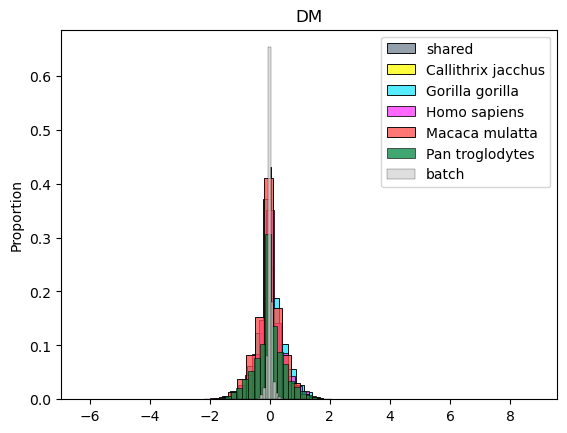

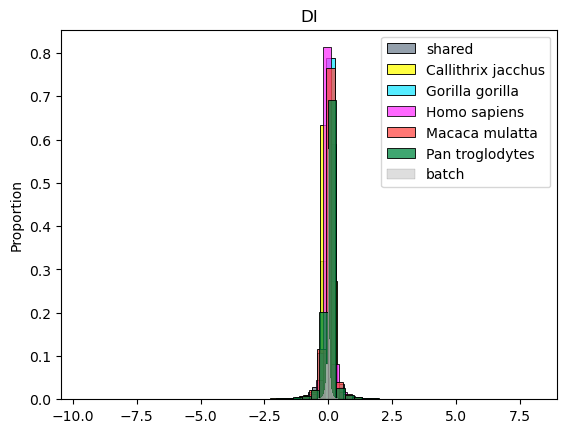

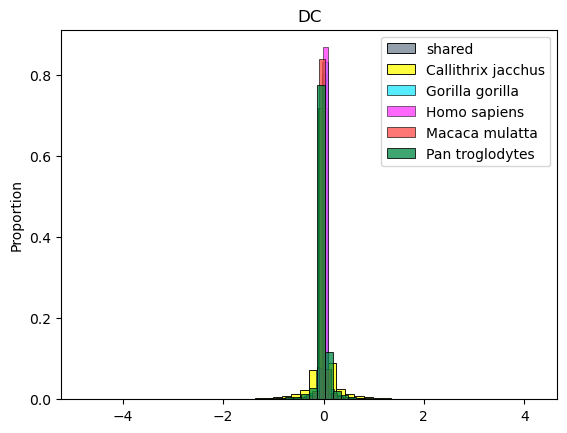

plot failed


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_species=antipode_model.adata_manager.adata.obs.groupby(antipode_model.batch_key)['species'].value_counts().unstack().idxmax(axis=1).to_dict()


In [14]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_batch_embedding_pca(antipode_model)

In [15]:
pstore=adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:]
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

In [16]:
aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key,'level_2'],layer=layer_key,normalize=True)
log_real_means=antipode.model_functions.safe_log_transform(aggr_means[0]) # #species,#cluster,#genes array

100%|██████████| 845/845 [02:18<00:00,  6.11it/s]


In [17]:
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=aggr_means[1]['level_2'])
real_means=real_means.loc[aggr_means[1]['level_2'],:]

In [18]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


/scratch/fast/8728/ipykernel_1822393/2048301033.py:6: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  fits.append(scipy.stats.stats.spearmanr(x,y).statistic)
/scratch/fast/8728/ipykernel_1822393/2048301033.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


0.853791314693198


Text(0.5, 1.0, '')

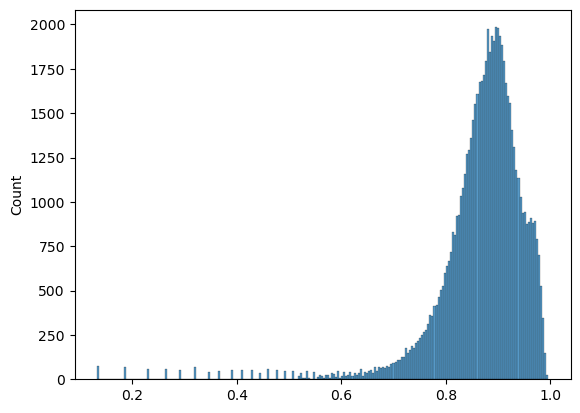

In [19]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

Text(0, 0.5, 'actual gene log mean')

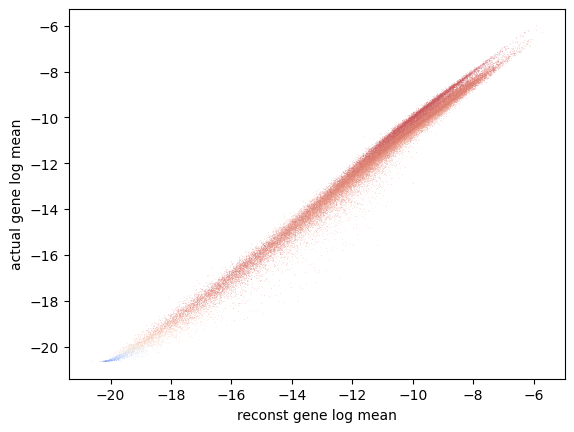

In [20]:
cmap = plt.cm.coolwarm

# Map 'fits' values to the colormap
colors = cmap(np.array(fits))
seaborn.scatterplot(x=discov_cluster_params.mean(1).flatten(),y=log_real_means.mean(1).flatten(),s=0.1,color=colors)
plt.xlabel('reconst gene log mean')
plt.ylabel('actual gene log mean')

In [21]:
print(cluster_index)
print(aggr_means[1]['level_2'])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  23  24  25  26  27  28  29  30  31  32  33  34  36  37
  38  39  40  41  42  43  44  47  48  49  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  76  78  80
  81  82  83  85  86  87  88  90  91  92  93  95  96  98  99 101 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 123
 124 126 127 128 129 130 131 133 134 136 138 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 156 157 158 159 160 161 162 163 164 165 167
 169 171 172 173 177 178 179 180 181 182 183 184 185 186 188 189 190 191
 192 193 194 195 196 197 198]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '41', '42', '43', '44', '47', '48', '49', '51', '52', '53', '54', '56', '57', '58', '59'

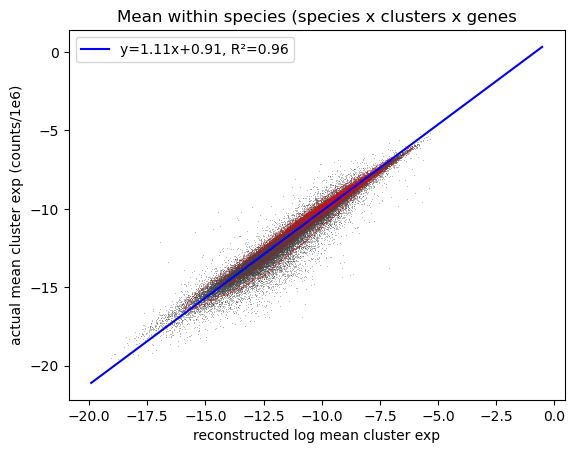

In [22]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
zeros=y>-20
x=x[zeros]
y=y[zeros]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

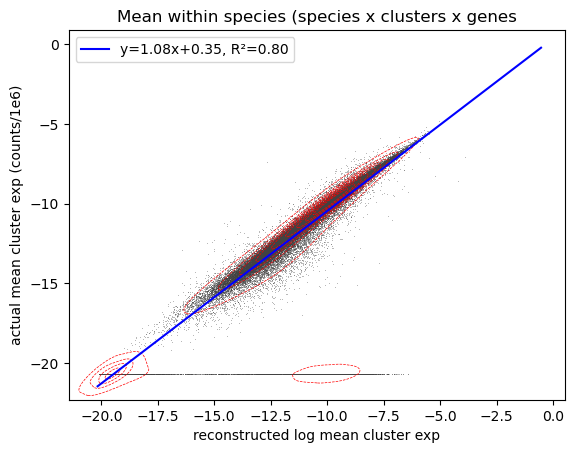

In [23]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

In [24]:
# antipode_model.save(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),save_anndata=True,prefix='p4_')

IORegistryError: No method registered for writing <class 'bytes'> into <class 'h5py._hl.group.Group'>